## Data Preparation and Modeling

Preparation

* Set the Stage for Binary Classifier
* Data Handling
* Balancing Data
* Train Test Spliting
* Data Augmentation

Modeling

* Neural Net Architecture
* Model Training, 5 Fold Cross Validtion
* Training/Validation Accuracy and Loss
* Test Data Evaluation
 - Prdiction
 - Confusion Matrix
 - ROC Curve

### Import the Required Dependencies

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
import os
import shutil
from zipfile import ZipFile
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics
from PIL import Image
from tensorflow.keras.metrics import AUC
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold


In [93]:
# Extract all the contents of zip file in current directory
with ZipFile('Patients_CT.zip', 'r') as zipObj:
  zipObj.extractall()

## Set the Stage for Binary Classifier  
This code snippet serves the purpose of sorting and classifying CT images into distinct folders depending on their labels (0 or 1) by utilizing data from a CSV file. It not only guarantees the presence of the intended destination folders but also manages the image copying process to ensure accurate arrangement.

In [94]:
# Function to create a folder if it doesn't exist
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Function to copy images to their respective folders
def copy_images(csv_file, folder_0, folder_1):
    # Read CSV file using pandas
    df = pd.read_csv(csv_file)
    df['Image'] = "/content/Patients_CT/"+df.iloc[:, 0].astype(str) + '/brain/' +df.iloc[:, 1].astype(str)+'.jpg'

    # Create destination folders if they don't exist
    create_folder_if_not_exists(folder_0)
    create_folder_if_not_exists(folder_1)

    # Loop through each row in the CSV and copy images to appropriate folders
    for index, row in df.iterrows():
        image_name = row['Image']

        label = row['No_Hemorrhage']

        source_path = os.path.join(image_name)
        aux = image_name.split('/')[-3:]
        des = ""
        for i in aux:
            des += i
        if label == 0:
            destination_path = os.path.join(folder_0, des)
        elif label == 1:
            destination_path = os.path.join(folder_1, des)
        else:
            # Skip if the label is not 0 or 1
            continue

        # Copy the image to the respective folder
        shutil.copy(image_name, destination_path)

# Set the paths and filenames
csv_file = "/content/Patients_CT/hemorrhage_diagnosis.csv"
folder_0 = "folder_for_label_0"
folder_1 = "folder_for_label_1"

# Call the function to copy the images
copy_images(csv_file, folder_0, folder_1)

In [95]:
# Number of images with hemorrhage
folder_hemo = os.listdir('folder_for_label_0')

# Number of images without hemorrhage
folder_no_hemo = os.listdir('folder_for_label_1')

print( 'Number of images with hemorrhage is:',len(folder_hemo))
print( 'Number of images without hemorrhage is:',len(folder_no_hemo))

Number of images with hemorrhage is: 318
Number of images without hemorrhage is: 2183


## Control Room

In [139]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width,Image_Height)
Image_Channels = 1
num_epochs = 20

## Data Handling
This code snippet prepares and structures CT image file paths and corresponding labels into a consolidated DataFrame for further analysis. We now possess a DataFrame that comprises the file paths of CT images as rows along with their corresponding labels.

In [140]:
nonhemorrhage = Path('/content/folder_for_label_1/')
hemorrhage = Path('/content/folder_for_label_0/')

# Find all the non hemorrhage pathnames matching .jpg
nonhemorrhage_filepaths = list(nonhemorrhage.glob('**/*.jpg'))

# Create a list of labels for a set of file paths related to non-hemorrhage cases
nonhemorrhage_labels = list(map(lambda x : 'nonhemorrhage', nonhemorrhage_filepaths))

# Convert the nonhemorrhage_filepaths list into a pandas Series with the name 'Filepath'
nonhemorrhage_filepaths = pd.Series(nonhemorrhage_filepaths , name = 'Filepath').astype(str)

# Convert the nonhemorrhage_labels list into a pandas Series with the name 'Label'
nonhemorrhage_labels = pd.Series(nonhemorrhage_labels, name = 'Label')

# Creates a new DataFrame called nonhemorrhage_df
nonhemorrhage_df = pd.concat([nonhemorrhage_filepaths, nonhemorrhage_labels], axis = 1)

# Find all the hemorrhage pathnames matching .jpg
hemorrhage_filepaths = list(hemorrhage.glob('**/*.jpg'))

# Create a list of labels for a set of file paths related to hemorrhage cases
hemorrhage_labels = list(map(lambda x : 'hemorrhage', hemorrhage_filepaths))

# Convert the hemorrhage_filepaths list into a pandas Series with the name 'Filepath'
hemorrhage_filepaths = pd.Series(hemorrhage_filepaths, name = 'Filepath').astype(str)

# Convert the hemorrhage_labels list into a pandas Series with the name 'Label'
hemorrhage_labels = pd.Series(hemorrhage_labels, name = 'Label')

# Creates a new DataFrame called hemorrhage_df
hemorrhage_df = pd.concat([hemorrhage_filepaths, hemorrhage_labels], axis = 1)

# Creates a new DataFrame called image_df
image_df = pd.concat([hemorrhage_df, nonhemorrhage_df])
print(image_df.shape)
image_df.sample(10)

(2501, 2)


,Filepath,Label
1080,/content/folder_for_label_1/110brain3.jpg,nonhemorrhage
177,/content/folder_for_label_0/67brain19.jpg,hemorrhage
1596,/content/folder_for_label_1/104brain11.jpg,nonhemorrhage
693,/content/folder_for_label_1/95brain2.jpg,nonhemorrhage
984,/content/folder_for_label_1/126brain19.jpg,nonhemorrhage
883,/content/folder_for_label_1/68brain20.jpg,nonhemorrhage
1645,/content/folder_for_label_1/65brain4.jpg,nonhemorrhage
2052,/content/folder_for_label_1/120brain9.jpg,nonhemorrhage
265,/content/folder_for_label_0/75brain31.jpg,hemorrhage
430,/content/folder_for_label_1/123brain16.jpg,nonhemorrhage


In [141]:
# Check the hemorrhage distribution
image_df['Label'].value_counts()

nonhemorrhage    2183
hemorrhage        318
Name: Label, dtype: int64

## Balancing Data
 This code snippet prepares a balanced dataset for training a binary classification model. It combines hemorrhage cases with a subset of non-hemorrhage cases (20%) to achieve a balanced representation of both classes. The dataset is shuffled for randomness before further processing or model training.

In [142]:
# Hemorrhage cases
image_df_hemo = image_df[image_df['Label'] == 'hemorrhage']
# Non-hemorrhage cases
image_df_nonhemo = image_df[image_df['Label'] == 'nonhemorrhage']
# Subset of non-hemorrhage image data
sampled_image_df_nonhemo = image_df_nonhemo.sample(frac=0.2)
# Create balanced dataset
image_df = pd.concat([image_df_hemo, sampled_image_df_nonhemo], ignore_index=True)
image_df = image_df.sample(frac=1 ).reset_index(drop=True)

In [143]:
# Size of the balanced data frame
print(image_df.shape)
image_df.sample(10)

(755, 2)


,Filepath,Label
136,/content/folder_for_label_0/71brain20.jpg,hemorrhage
283,/content/folder_for_label_0/71brain12.jpg,hemorrhage
403,/content/folder_for_label_0/75brain23.jpg,hemorrhage
753,/content/folder_for_label_1/74brain31.jpg,nonhemorrhage
367,/content/folder_for_label_1/88brain1.jpg,nonhemorrhage
432,/content/folder_for_label_1/123brain8.jpg,nonhemorrhage
23,/content/folder_for_label_1/116brain21.jpg,nonhemorrhage
511,/content/folder_for_label_0/90brain16.jpg,hemorrhage
95,/content/folder_for_label_0/80brain16.jpg,hemorrhage
433,/content/folder_for_label_0/78brain13.jpg,hemorrhage


In [144]:
# Check the class
image_df['Label'].value_counts()

nonhemorrhage    437
hemorrhage       318
Name: Label, dtype: int64

## Train Test Spliting
The training set, which comprised 80% of the data and is employed for model training, and the test set, representing 20% of the data, which is reserved for performance evaluation. Additionally, during the augmentation process, a validation subset, amounting to approximately 20% of the training data, is set aside. This validation data played a vital role in evaluating the model's performance throughout the training phase, aiding in the identification of potential overfitting.

In [145]:
train_df, test_df = train_test_split(image_df, test_size = 0.2, shuffle = True, random_state = 1)
print('number of hemorrhage images used for training: ', len(train_df[train_df['Label'] == 'hemorrhage']))
print('number of nonhemorrhage images used for training: ',len(train_df[train_df['Label'] == 'nonhemorrhage']))

number of hemorrhage images used for training:  263
number of nonhemorrhage images used for training:  341


In [146]:
# Train dataset
train_df['Label'].value_counts()

nonhemorrhage    341
hemorrhage       263
Name: Label, dtype: int64

In [147]:
# Test dataset
test_df['Label'].value_counts()

nonhemorrhage    96
hemorrhage       55
Name: Label, dtype: int64

## Data Augmentation
Image augmentation is a powerful technique used in deep learning to enhance the diversity and quantity of training data. It involves applying various transformations to the original images, creating multiple transformed copies that differ in certain aspects. These transformations can include shifting, rotating, flipping, and more. The purpose of image augmentation is not to alter the target class of the image but to offer new perspectives on how the object appears in real life.

If the value of height_shift_range or width_shift_range is a float number between 0 and 1, it indicates the percentage of the image's height or width to shift. For example, if height_shift_range=0.2, it means the image can be vertically shifted by up to 20% of its height. horizontal_flip parameter allows the images to be horizontally flipped. It means that the images are mirrored along the vertical axis. For example, if the image has a hemorrhage facing left, the horizontally flipped version of the image will have the hemorrhage facing right.

We used the flow_from_dataframe() method to read the images from the specified directory and perform image augmentation on-the-fly based on the information provided in the dataframe. The DataFrameIterator is an iterator that generates batches of image data and their corresponding target values (labels) from a dataframe.

In [148]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    validation_split = 0.20,

)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)

train_image = train_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (Image_Width,Image_Height),
    color_mode = 'grayscale',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)
val_image = train_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (Image_Width,Image_Height),
    color_mode = 'grayscale',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)
test_image = train_gen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (Image_Width,Image_Height),
    color_mode = 'grayscale',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False,
)

Found 484 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 151 validated image filenames belonging to 2 classes.


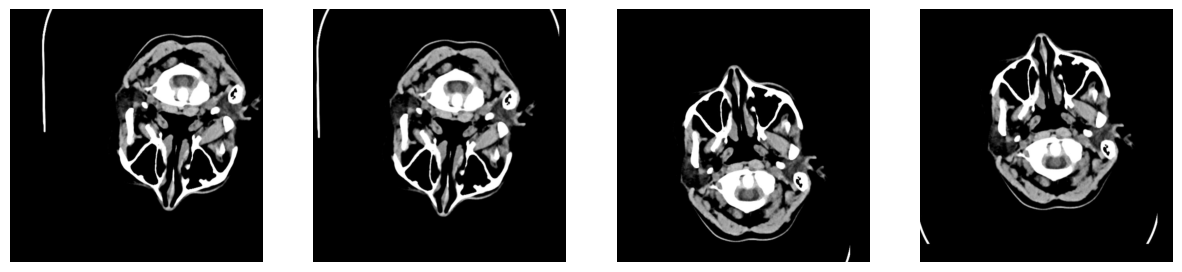

In [149]:
# A sample of augmentation
path = '/content/folder_for_label_1/105brain6.jpg'
img=plt.imread(path)
datagen = ImageDataGenerator( horizontal_flip = True,
    width_shift_range = 0.20,
    height_shift_range = 0.20,
      vertical_flip=True)
# Converting the input sample image to an array
x  = np.array(img, dtype="float")
# Reshaping the input image
x = x.reshape((1, ) + x.shape)
x= x.reshape(1, 650, 650, 1)
aug_iter = datagen.flow(x, batch_size=1)
# Generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
# Generate batch of images
for i in range(4):
  # Convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
  # Plot image
	ax[i].imshow(image, cmap='gray')
	ax[i].axis('off')


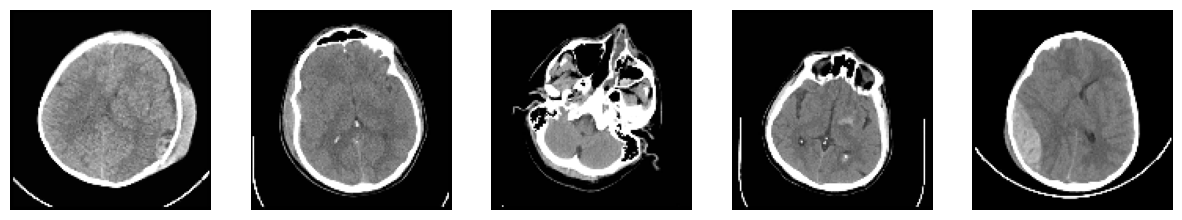

In [150]:
# Plotting the first 5 image in train_image set
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
  image = next(train_image)[0][0]
  image = np.squeeze(image)
  ax[i].imshow(image, cmap='gray')
  ax[i].axis('off')


In [151]:
# Dimensions of the batch of data and labels
X_train, Y_train = next(train_image)

print(X_train.shape)
print(Y_train.shape)

(32, 128, 128, 1)
(32,)


label is : 1.0


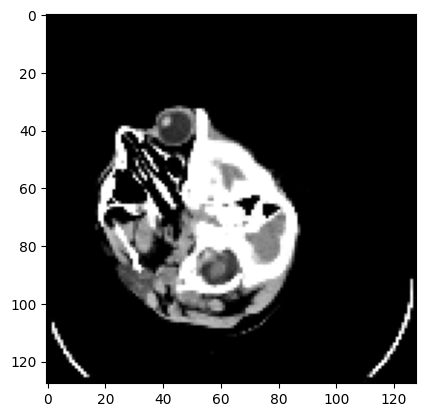

In [152]:
# Print the first image in X_train
img = X_train[1,:,:,:]

# Print the image label
print('label is :', Y_train[31,])
plt.imshow(img, cmap= 'gray')

## Neural Net Architecture

In [153]:
# Define the model architecture
input_shape = (Image_Height,Image_Width,Image_Channels)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy',AUC()])
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 57600)             0         
                                                                 
 dense_90 (Dense)            (None, 256)             

## Model Training, 5 Fold Cross Validtion
This code snippet implements a k-fold cross-validation process for training and evaluating the model using the 5 folds. It provides a robust assessment of the model's performance on different subsets of the training data and reports the average accuracy and loss across all folds. Using multiple train-validation splits helps in identifying whether the model's performance is consistent across different subsets of the data. It reduces the risk of overfitting to a specific train-test split and gives us a more accurate estimate of how well the model generalizes to unseen data.

In [154]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(train_image):
  input_shape = (Image_Height,Image_Width,Image_Channels)
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy',AUC()])
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(train_image, validation_data = val_image,
              batch_size=50,
              epochs=num_epochs,
              verbose=1,
                      callbacks = tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 6,
            restore_best_weights = True))


  # Generate generalization metrics
  scores = model.evaluate(val_image, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')




------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
16/16 [==============================] - 12s 579ms/step - loss: 0.6475 - accuracy: 0.6198 - auc_31: 0.6836 - val_loss: 0.5095 - val_accuracy: 0.7417 - val_auc_31: 0.8287
Epoch 2/20
16/16 [==============================] - 10s 583ms/step - loss: 0.4457 - accuracy: 0.7810 - auc_31: 0.8661 - val_loss: 0.4709 - val_accuracy: 0.7333 - val_auc_31: 0.8631
Epoch 3/20
16/16 [==============================] - 10s 618ms/step - loss: 0.3612 - accuracy: 0.8244 - auc_31: 0.9176 - val_loss: 0.3811 - val_accuracy: 0.8333 - val_auc_31: 0.9192
Epoch 4/20
16/16 [==============================] - 10s 635ms/step - loss: 0.2416 - accuracy: 0.9112 - auc_31: 0.9655 - val_loss: 0.3117 - val_accuracy: 0.8583 - val_auc_31: 0.9422
Epoch 5/20
16/16 [==============================] - 10s 618ms/step - loss: 0.1619 - accuracy: 0.9463 - auc_31: 0.9844 - val_loss: 0.3062 - val_accuracy: 0.8667 - val_auc_31: 0.938

In [155]:
# Saving model
model.save("binary_classifier_cnn_hemorrhage.h5")

## Training/Validation Accuracy and Loss

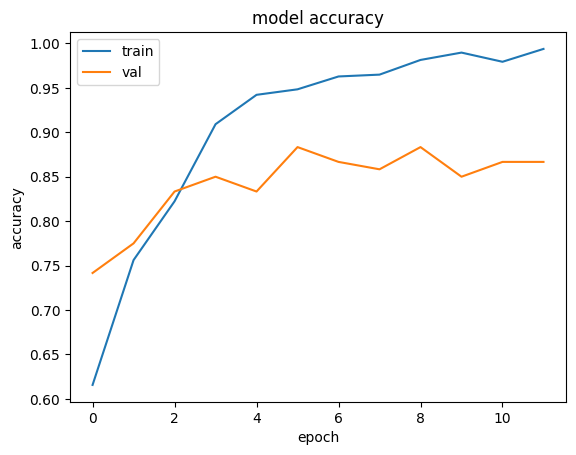

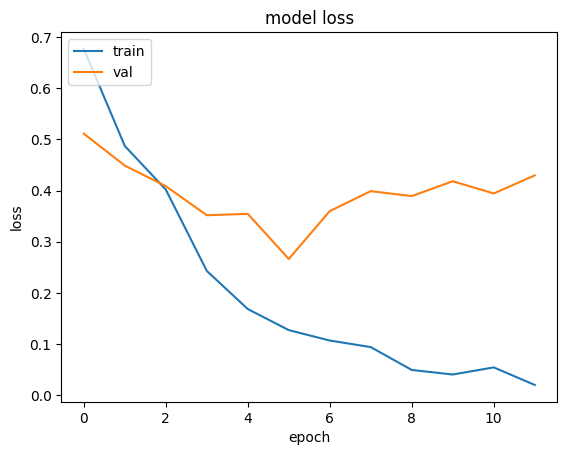

In [156]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test Data Evaluation
In the following steps, the trained model will be utilized to classify the images in the test set. Subsequently, we will showcase the results through the use of a confusion matrix and a receiver operating characteristic (ROC) curve.


### Prediction

In [157]:
# Prediction on test data
prediction=model.predict(test_image)

5/5 [==============================] - 1s 132ms/step


With the use of this code, we take the continuous predictions generated by the model and apply a threshold of 0.5. This thresholding process transforms the predictions into binary class predictions. When a prediction is above 0.5, it's categorized as belonging to the positive class (hemmorhage); otherwise, it's categorized as the negative class (non-hemorrhage).

In [158]:
y_pred = np.where(prediction > 0.5, 1, 0)

### Confusion Matrix
A confusion matrix is a table that summarizes the performance of a classification model. It shows the number of true positive, true negative, false positive, and false negative predictions. This helps in assessing how well the model is classifying instances for each class. From the confusion matrix, various metrics like accuracy, precision, recall, and F1-score can be calculated to evaluate the model's performance.

[[51  4]
 [25 71]]
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        55
           1       0.95      0.74      0.83        96

    accuracy                           0.81       151
   macro avg       0.81      0.83      0.80       151
weighted avg       0.85      0.81      0.81       151



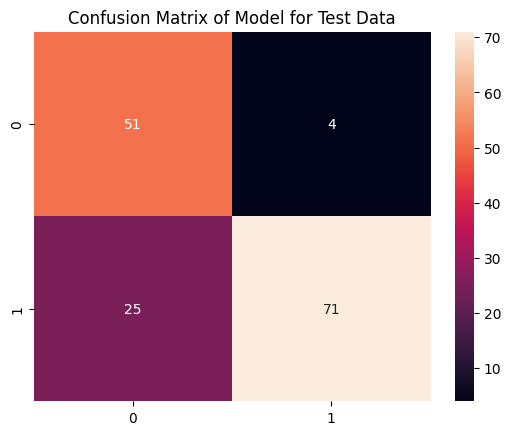

In [159]:
# Define the true class for each image in the test data
y_true=test_image.classes

# Confusion matrix
cm=confusion_matrix(y_true,y_pred)
print(cm)
sns.heatmap(cm,annot=True).set_title('Confusion Matrix of Model for Test Data')
print(classification_report(y_true,y_pred))

### ROC Curve
The ROC curve is a graphical representation that shows the trade-off between a binary classification model's ability to correctly classify positive instances (sensitivity) and its tendency to incorrectly classify negative instances as positive (1 - specificity). It's a way to visualize and evaluate a model's performance at different classification thresholds. The area under the ROC curve (AUC-ROC) summarizes the overall performance: higher values indicate better performance, with 1 being ideal and 0.5 indicating random guessing.

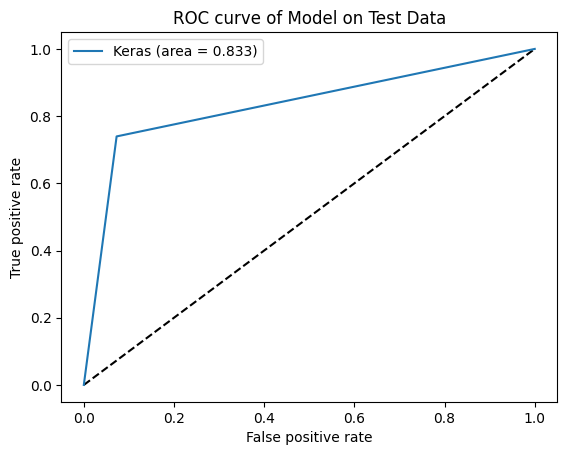

In [160]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Model on Test Data')
plt.legend(loc='best')
plt.show()


### Bibliography

Versloot, C.(2022). *how to use k-fold cross validation with keras*.
github. Retrieved August 12, 2023, from https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md